### Read in datasets
#### All data is from American Community Survey 2010-2012 Public Use Microdata Series.

In [2]:
import numpy as np
import pandas as pd

all_ages = pd.read_csv("all-ages.csv")
grad_students = pd.read_csv("grad-students.csv")
majors_list = pd.read_csv("majors-list.csv")
recent_grads = pd.read_csv("recent-grads.csv")
women_stem = pd.read_csv("women-stem.csv")

### Create categories dataset with unique majors and their respective gender ratios


In [6]:
recent_grads['Gender_Ratio'] = recent_grads['Men']/recent_grads['Women']
recent_grads.rename(columns={'Major_category': 'Career'}, inplace=True)
# Fix NaN and inf values
for i, value in enumerate([bool(np.isnan(ratio) or not np.isfinite(ratio)) for ratio in recent_grads['Gender_Ratio']]):
    if value:
        recent_grads.at[i, 'Gender_Ratio'] = recent_grads[recent_grads['Career'] == recent_grads['Career'][i]].drop(i)['Gender_Ratio'].mean()

In [7]:
categories_list = []
for Crr in recent_grads.Career.unique():
    Gender_Ratio = recent_grads[recent_grads['Career'] == Crr]['Gender_Ratio'].mean()
    categories_list.append([Crr, Gender_Ratio])
categories = pd.DataFrame(data=categories_list, columns=['Career', 'Gender_Ratio_M/F'])

categories

,Career,Gender_Ratio_M/F
0,Engineering,4.145887
1,Business,1.233494
2,Physical Sciences,1.152878
3,Law & Public Policy,1.343656
4,Computers & Mathematics,2.618559
5,Agriculture & Natural Resources,2.180908
6,Industrial Arts & Consumer Services,3.687606
7,Arts,0.744159
8,Health,0.286838
9,Social Science,0.918837


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


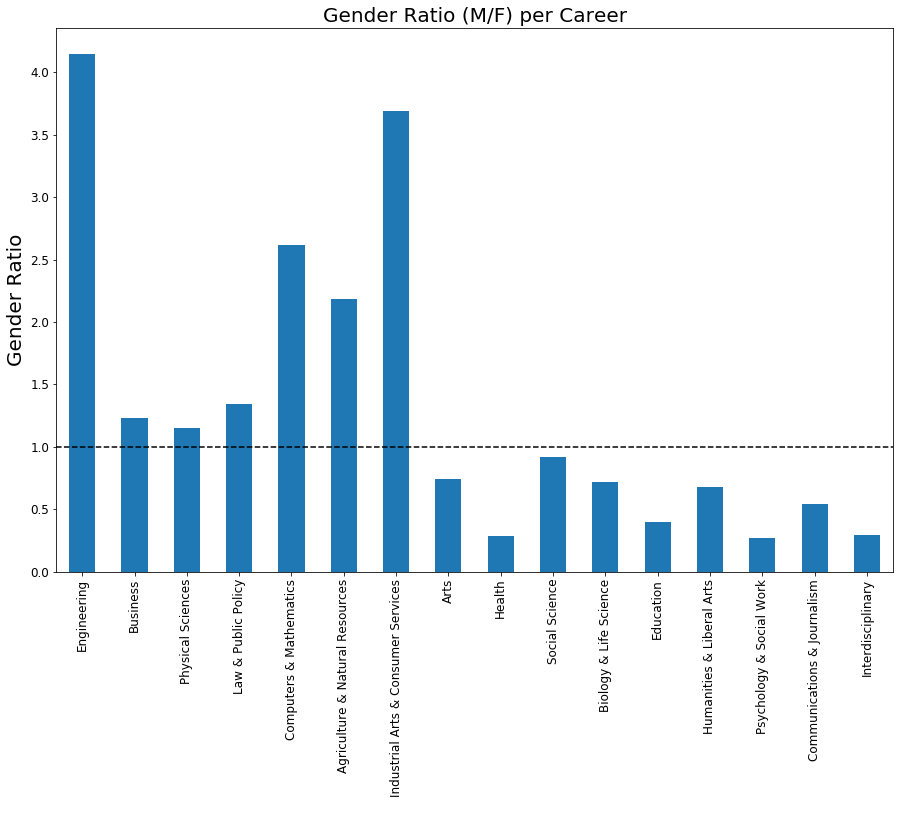

In [8]:
# Graph our results
import matplotlib.pyplot as plt
%matplotlib inline
ax = categories.plot(kind='bar', figsize=(15, 10), legend=False, fontsize=12)
ax.set_xticklabels(labels=categories['Career'])
ax.set_xlabel("Career", fontsize=20, color='white')
ax.set_ylabel("Gender Ratio", fontsize=20)
ax.set_title("Gender Ratio (M/F) per Career", fontsize=20)
ax.axhline(y=1, xmin=0, xmax=4.5, color = 'k', linestyle='--')
plt.show()

#### We want to do one-hot-encoding on the categorical variable 'Career' so it can be used in a linear model.

In [9]:
recent_gradsdf = pd.get_dummies(recent_grads, columns=['Career'])

#### Now we create our Linear Regression Model

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

def createLinearModel(df, drop_cols):
    df_cols = list(df.columns.values)
    for drop_col in drop_cols:
        df_cols.remove(drop_col)
    X = df[df_cols]
    y = df['Median']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
#     print("Coef Labels: ")
#     coefs = dict(zip(df_cols, model.coef_))
#     for coef in coefs:
#         print(coef, coefs[coef])
    print(df_cols)
    print([ round(elem, 2) for elem in y_pred ])
    print('\nMAE: %.2f' % metrics.mean_absolute_error(y_test, y_pred))
    print('MSE: %.2f' % metrics.mean_squared_error(y_test, y_pred))
    print('RMSE: %.2f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    return model

drop_columns = ['Rank', 'Major_code', 'Major', 'Total', 'Men', 'Women','ShareWomen', 'Sample_size','Full_time', 'Part_time','Full_time_year_round', 'Unemployed', 'Unemployment_rate','Median', 'P25th', 'P75th','Non_college_jobs','Low_wage_jobs']

createLinearModel(recent_gradsdf, drop_columns)
print('------------------------')
print('Employed Removed:\n')
drop_columns.append('Employed')
createLinearModel(recent_gradsdf, drop_columns)
print('------------------------')
print('College_jobs Removed:\n')
drop_columns.append('College_jobs')
best_model = createLinearModel(recent_gradsdf, drop_columns)

['Employed', 'College_jobs', 'Gender_Ratio', 'Career_Agriculture & Natural Resources', 'Career_Arts', 'Career_Biology & Life Science', 'Career_Business', 'Career_Communications & Journalism', 'Career_Computers & Mathematics', 'Career_Education', 'Career_Engineering', 'Career_Health', 'Career_Humanities & Liberal Arts', 'Career_Industrial Arts & Consumer Services', 'Career_Interdisciplinary', 'Career_Law & Public Policy', 'Career_Physical Sciences', 'Career_Psychology & Social Work', 'Career_Social Science']
[30497.89, 32157.28, 41523.21, 33479.19, 43911.55, 33316.88, 35372.78, 57630.87, 43528.8, 37916.02, 60797.46, 54281.1, 41974.9, 44369.97, 38037.87, 45486.52, 31328.47, 43598.7, 36563.16, 55070.48, 33856.85, 37367.9, 32104.28, 38094.34, 39203.16, 43971.64, 41582.79, 37406.03, 53530.84, 32748.22, 34433.15, 29989.06, 33083.16, 59994.07, 33799.64, 43101.44, 37860.13, 44353.31, 34273.39, 34796.41, 35401.88, 45672.52, 32713.65, 42406.59, 37469.24, 34493.5, 46795.16, 53668.68, 53294.37, 52

#### We do the same with a Logistic Regression model

In [12]:
def createLogisticModel(df, drop_cols):
    df_cols = list(df.columns.values)
    for drop_col in drop_cols:
        df_cols.remove(drop_col)
    X = df[df_cols]
    y = df['Median']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    model = LogisticRegression(penalty='l1', C=2.7825594022071245)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('\nMAE: %.2f' % metrics.mean_absolute_error(y_test, y_pred))
    print('MSE: %.2f' % metrics.mean_squared_error(y_test, y_pred))
    print('RMSE: %.2f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    return y_pred


drop_columns = ['Rank', 'Major_code', 'Major', 'Total', 'Men', 'Women','ShareWomen', 'Sample_size','Full_time', 'Part_time','Full_time_year_round', 'Unemployed', 'Unemployment_rate','Median', 'P25th', 'P75th','Non_college_jobs','Low_wage_jobs']

createLogisticModel(recent_gradsdf, drop_columns)


MAE: 7089.66
MSE: 116929310.34
RMSE: 10813.39


array([35000, 32000, 36000, 27500, 45000, 32000, 35000, 60000, 50000,
       40000, 60000, 60000, 45000, 45000, 38000, 40000, 28000, 38000,
       32000, 40000, 35000, 75000, 34000, 75000, 44000, 40000, 45000,
       36000, 60000, 44000, 40000, 30000, 34000, 40000, 32000, 62000,
       36000, 44000, 35000, 37000, 40000, 40000, 34000, 44700, 33000,
       35000, 45000, 42000, 52000, 60000, 32000, 47000, 30500, 52000,
       35000, 35000, 60000, 34000])

#### Using RMSE as our metric of choice, a Linear Regression model outperformed a Logistic Regression model.

The most important features to predict Median salary is 'Employed', 'College_jobs', 'Gender_Ratio', and 'Career' with an RMSE of 5879.62.

#### Other Questions:

In [43]:
# Lowest 10 Unemployment  Rates by Major
for combo in recent_grads.sort_values('Unemployment_rate', ascending=True)[['Major', 'Unemployment_rate']].head(10).values:
    print(combo)

['EDUCATIONAL ADMINISTRATION AND SUPERVISION' 0.0]
['MILITARY TECHNOLOGIES' 0.0]
['BOTANY' 0.0]
['MATHEMATICS AND COMPUTER SCIENCE' 0.0]
['SOIL SCIENCE' 0.0]
['ENGINEERING MECHANICS PHYSICS AND SCIENCE' 0.006334343]
['COURT REPORTING' 0.011689692]
['MATHEMATICS TEACHER EDUCATION' 0.016202835]
['PETROLEUM ENGINEERING' 0.018380527]
['GENERAL AGRICULTURE' 0.019642463]


In [54]:
# Medians
median_list = []
for Crr in recent_grads.Career.unique():
    Median = recent_grads[recent_grads['Career'] == Crr]['Median'].mean()
    median_list.append(Median)
categories['Median'] = median_list

# Lowest 5 Median Careers
for combo in categories.sort_values('Median', ascending=False)[['Career', 'Median']].head(5).values:
    print(combo)

['Engineering' 57382.75862068965]
['Business' 43538.46153846154]
['Computers & Mathematics' 42745.454545454544]
['Law & Public Policy' 42200.0]
['Physical Sciences' 41890.0]


In [65]:
#IQRs
iqr_list = []
for Crr in recent_grads.Career.unique():
    iqr = (recent_grads[recent_grads['Career'] == Crr]['P75th'] - recent_grads[recent_grads['Career'] == Crr]['P25th']).mean()
    iqr_list.append(iqr)
categories['IQR'] = iqr_list

# Lowest 5 IQR Careers
for combo in categories.sort_values('IQR', ascending=True)[['Career', 'IQR']].head(5).values:
    print(combo)

['Education' 11971.875]
['Psychology & Social Work' 13444.444444444445]
['Industrial Arts & Consumer Services' 18371.428571428572]
['Humanities & Liberal Arts' 18580.0]
['Communications & Journalism' 18725.0]


In [66]:
recent_grads.head()

,Rank,Major_code,Major,Total,Men,Women,Career,ShareWomen,Sample_size,Employed,...,Full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th,College_jobs,Non_college_jobs,Low_wage_jobs,Gender_Ratio
0,1,2419,PETROLEUM ENGINEERING,2339.0,2057.0,282.0,Engineering,0.120564,36,1976,...,1207,37,0.018381,110000,95000,125000,1534,364,193,7.294326
1,2,2416,MINING AND MINERAL ENGINEERING,756.0,679.0,77.0,Engineering,0.101852,7,640,...,388,85,0.117241,75000,55000,90000,350,257,50,8.818182
2,3,2415,METALLURGICAL ENGINEERING,856.0,725.0,131.0,Engineering,0.153037,3,648,...,340,16,0.024096,73000,50000,105000,456,176,0,5.534351
3,4,2417,NAVAL ARCHITECTURE AND MARINE ENGINEERING,1258.0,1123.0,135.0,Engineering,0.107313,16,758,...,692,40,0.050125,70000,43000,80000,529,102,0,8.318519
4,5,2405,CHEMICAL ENGINEERING,32260.0,21239.0,11021.0,Engineering,0.341631,289,25694,...,16697,1672,0.061098,65000,50000,75000,18314,4440,972,1.927139
